In [2]:
!pip install yfinance

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 17.7 MB/s eta 0:00:00m eta 0:00:010:01:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 41.5 MB/s eta 0:00:00m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.3/173.3 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 19.4 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15548 sha256=0b936097575d63dfb464c9a4471f01cd404eeb6897ffea269ea200a6acd747e3
  Stored in directory: /Users/hetshah/Library/Caches/pip/wheels/42/d6/84/bf57a755f4569494cd00de4bb46ef064874823f4d19c82e960
  Created wheel for peewee: filename=peewee-3.18.3-cp311-cp311-macosx_11_0_arm64.whl size=271541 sha2

/var/folders/lx/886qfh6x2790nj72rdq32rv00000gn/T/ipykernel_41892/837452928.py:34: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = period_prices.resample('M').last()


SPY 15-YEAR INVESTMENT ANALYSIS
Initial Investment: $1,000,000


Start Date: 1995-01-01
End Date: 2009-12-31
------------------------------------------------------------
Starting SPY Price: $26.66
Ending SPY Price: $83.86
Total Return Multiplier: 3.0574x
Final Investment Value: $3,057,429.09
Total Gain: $2,057,429.09
Annualized Return: 7.74%

Start Date: 2000-01-01
End Date: 2014-12-31
------------------------------------------------------------
Starting SPY Price: $91.89
Ending SPY Price: $171.19
Total Return Multiplier: 1.9414x
Final Investment Value: $1,941,406.34
Total Gain: $941,406.34
Annualized Return: 4.52%

Start Date: 2005-01-01
End Date: 2019-12-31
------------------------------------------------------------
Starting SPY Price: $81.85
Ending SPY Price: $295.81
Total Return Multiplier: 3.6797x
Final Investment Value: $3,679,661.51
Total Gain: $2,679,661.51
Annualized Return: 9.07%

Start Date: 2008-01-01
End Date: 2022-12-30
---------------------------------------------------

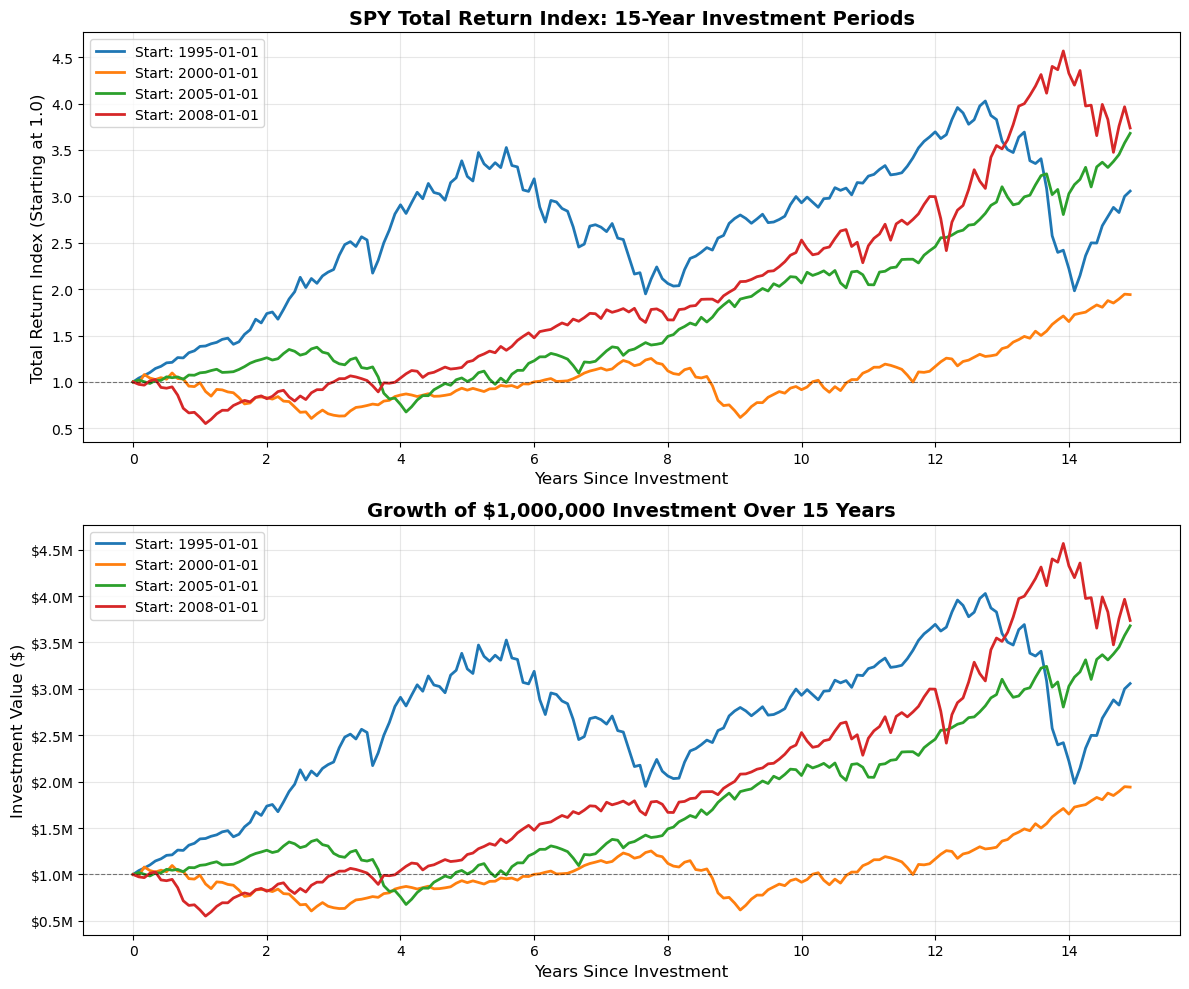


SUMMARY STATISTICS
Average Final Value: $3,103,943.06
Median Final Value: $3,368,545.30
Standard Deviation: $722,187.06
Range: $1,795,868.95
Coefficient of Variation: 23.27%


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


spy = yf.download('SPY', start='1994-12-01', end='2023-12-31', progress=False, auto_adjust=False)

# Handle MultiIndex columns if present
if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = spy.columns.droplevel(1)

# Use adjusted close prices (includes dividends)
prices = spy['Adj Close'].copy()

# Define investment start dates and calculate end dates
start_dates = ['1995-01-01', '2000-01-01', '2005-01-01', '2008-01-01']
initial_investment = 1_000_000

results = {}

for start_date in start_dates:
    # Calculate end date (exactly 15 years later)
    start_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = start_dt + timedelta(days=15*365.25)  # Account for leap years
    end_date = end_dt.strftime('%Y-%m-%d')
    
    # Filter data for this period
    mask = (prices.index >= start_date) & (prices.index <= end_date)
    period_prices = prices[mask].copy()
    
    # Resample to monthly (end of month)
    monthly_prices = period_prices.resample('M').last()
    
    # Calculate monthly returns
    monthly_returns = monthly_prices.pct_change()
    
    # Calculate total return index (starting at 1.0)
    total_return_index = (1 + monthly_returns).cumprod()
    total_return_index.iloc[0] = 1.0  # Set first value to 1.0
    
    # Calculate final investment value
    final_multiplier = total_return_index.iloc[-1]
    final_value = initial_investment * final_multiplier
    
    # Calculate annualized return
    years = len(monthly_returns) / 12
    annualized_return = (final_multiplier ** (1/years)) - 1
    
    # Store results
    results[start_date] = {
        'total_return_index': total_return_index,
        'final_value': final_value,
        'final_multiplier': final_multiplier,
        'annualized_return': annualized_return,
        'start_price': period_prices.iloc[0],
        'end_price': period_prices.iloc[-1],
        'actual_end_date': period_prices.index[-1].strftime('%Y-%m-%d')
    }

# Print results
print("="*80)
print("SPY 15-YEAR INVESTMENT ANALYSIS")
print("="*80)
print(f"Initial Investment: ${initial_investment:,.0f}\n")

for start_date in start_dates:
    r = results[start_date]
    print(f"\nStart Date: {start_date}")
    print(f"End Date: {r['actual_end_date']}")
    print(f"-" * 60)
    print(f"Starting SPY Price: ${r['start_price']:.2f}")
    print(f"Ending SPY Price: ${r['end_price']:.2f}")
    print(f"Total Return Multiplier: {r['final_multiplier']:.4f}x")
    print(f"Final Investment Value: ${r['final_value']:,.2f}")
    print(f"Total Gain: ${r['final_value'] - initial_investment:,.2f}")
    print(f"Annualized Return: {r['annualized_return']*100:.2f}%")

# Find best and worst performers
best_start = max(results.keys(), key=lambda x: results[x]['final_value'])
worst_start = min(results.keys(), key=lambda x: results[x]['final_value'])

print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)
print(f"\nBEST PERFORMING START DATE: {best_start}")
print(f"  Final Value: ${results[best_start]['final_value']:,.2f}")
print(f"  Annualized Return: {results[best_start]['annualized_return']*100:.2f}%")

print(f"\nWORST PERFORMING START DATE: {worst_start}")
print(f"  Final Value: ${results[worst_start]['final_value']:,.2f}")
print(f"  Annualized Return: {results[worst_start]['annualized_return']*100:.2f}%")

print(f"\nDifference: ${results[best_start]['final_value'] - results[worst_start]['final_value']:,.2f}")
print(f"({(results[best_start]['final_value'] / results[worst_start]['final_value'] - 1)*100:.1f}% higher)")

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Total Return Index
for start_date in start_dates:
    idx = results[start_date]['total_return_index']
    # Create x-axis as years from start
    x_years = np.arange(len(idx)) / 12
    ax1.plot(x_years, idx, label=f'Start: {start_date}', linewidth=2)

ax1.set_xlabel('Years Since Investment', fontsize=12)
ax1.set_ylabel('Total Return Index (Starting at 1.0)', fontsize=12)
ax1.set_title('SPY Total Return Index: 15-Year Investment Periods', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=1.0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

# Plot 2: Investment Value
for start_date in start_dates:
    idx = results[start_date]['total_return_index']
    investment_value = idx * initial_investment
    x_years = np.arange(len(idx)) / 12
    ax2.plot(x_years, investment_value, label=f'Start: {start_date}', linewidth=2)

ax2.set_xlabel('Years Since Investment', fontsize=12)
ax2.set_ylabel('Investment Value ($)', fontsize=12)
ax2.set_title(f'Growth of ${initial_investment:,.0f} Investment Over 15 Years', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=initial_investment, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
final_values = [results[sd]['final_value'] for sd in start_dates]
print(f"Average Final Value: ${np.mean(final_values):,.2f}")
print(f"Median Final Value: ${np.median(final_values):,.2f}")
print(f"Standard Deviation: ${np.std(final_values):,.2f}")
print(f"Range: ${max(final_values) - min(final_values):,.2f}")
print(f"Coefficient of Variation: {np.std(final_values)/np.mean(final_values):.2%}")